In [310]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from geopy.geocoders import Nominatim
import requests

#plotting libraries and modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium #maps and geospatial plots
from folium import plugins
from folium.plugins import MeasureControl
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [183]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [184]:
import json #to consume geolocation file in json format
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [185]:
Neighborhood_data = newyork_data['features']

In [186]:
colnames = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
Neighborhood_df = pd.DataFrame(columns= colnames)

In [187]:
for data in Neighborhood_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']
    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    Neighborhood_df = Neighborhood_df.append({'Borough' : borough,
                            'Neighborhood' : neighborhood_name,
                          'Latitude' : neighborhood_lat,
                          'Longitude' : neighborhood_lon}, ignore_index = True)

In [188]:
print(Neighborhood_df.shape)

(306, 4)


In [189]:
print('The dataframe has {} Boroughs and {} neighborhoods of New York City'
      .format(len(Neighborhood_df['Borough'].unique()),Neighborhood_df.shape[0]))

The dataframe has 5 Boroughs and 306 neighborhoods of New York City


In [190]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geogrpahic location of New York is {}, {}'. format(latitude, longitude))

Geogrpahic location of New York is 40.7127281, -74.0060152


In [309]:
NY_map = folium.Map(location = [latitude,longitude], zoom_start = 10)
NY_map

for lat, lon, Neighborhood, Borough in zip(Neighborhood_df['Latitude'], Neighborhood_df['Longitude'],
                                          Neighborhood_df['Neighborhood'], Neighborhood_df['Borough']):
    label = '{}, {}'. format(Neighborhood, Borough)
    folium.CircleMarker(
        [lat, lon],
        popup = label,
        radius = 5,
        color = 'blue',
        fill = True,
        fill_color = 'yellow',
        fill_opacity = 0.7,
        parse_html = False).add_to(NY_map)

NY_map

In [192]:
def getNearbyVenues(access_token, version, LIMIT, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(
            access_token, 
            version, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [196]:
token = 'RBPLNFEVFSX5N12KWCQY35ZZNPIDEE0Q5WWWSEFMJLICKMD3'
limit = 100
version = '20180301'
manhattan_data = Neighborhood_df[Neighborhood_df['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_venues = getNearbyVenues(token,version,limit,manhattan_data['Neighborhood'],manhattan_data['Latitude'],manhattan_data['Longitude'])
manhattan_venues.shape
'''neighborhood_venues=getNearbyVenues(token,version,limit,Neighborhood_df['Neighborhood'],
                                    Neighborhood_df['Latitude'],Neighborhood_df['Longitude'])
neighborhood_venues.shape'''

"neighborhood_venues=getNearbyVenues(token,version,limit,Neighborhood_df['Neighborhood'],\n                                    Neighborhood_df['Latitude'],Neighborhood_df['Longitude'])\nneighborhood_venues.shape"

In [197]:
manhattan_venues.to_csv('/kaggle/working/manhattan_venues.csv')

In [198]:
Neighborhood_df.loc[0:,'Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [199]:
Bronx_data = Neighborhood_df[Neighborhood_df.loc[0:,'Borough']=='Bronx']
Bronx_venues = getNearbyVenues(token,version,limit,Bronx_data['Neighborhood'],Bronx_data['Latitude'],Bronx_data['Longitude'])
Bronx_venues.shape

(2679, 7)

In [201]:
Queens_data = Neighborhood_df[Neighborhood_df.loc[0:,'Borough']=='Queens']
Queens_venues = getNearbyVenues(token,version,limit,Queens_data['Neighborhood'],Queens_data['Latitude'],Queens_data['Longitude'])
Queens_venues.shape

(3496, 7)

In [202]:
StatenIsland_data = Neighborhood_df[Neighborhood_df.loc[0:,'Borough']=='Staten Island']
StatenIsland_venues = getNearbyVenues(token,version,limit,StatenIsland_data['Neighborhood'],StatenIsland_data['Latitude'],StatenIsland_data['Longitude'])
StatenIsland_venues.shape

(2138, 7)

In [203]:
Brooklyn_data = Neighborhood_df[Neighborhood_df.loc[0:,'Borough']=='Brooklyn']
Brooklyn_venues = getNearbyVenues(token,version,limit,Brooklyn_data['Neighborhood'],Brooklyn_data['Latitude'],Brooklyn_data['Longitude'])
Brooklyn_venues.shape

(3998, 7)

In [204]:
Bronx_venues.to_csv('/kaggle/working/bronx_vnues.csv')
Brooklyn_venues.to_csv('/kaggle/working/brooklyn_venues.csv')
Queens_venues.to_csv('/kaggle/working/queens_venues.csv')
StatenIsland_venues.to_csv('/kaggle/working/statenIsland_venues.csv')

### Dataframe and chart with Boroughs and fitness options per Borough

In [205]:
def filter_venues(df,string):
    df_filtered = pd.DataFrame(columns=df.columns)
    df_filtered = df[df['Venue Category']==string]
    return df_filtered

### Curated List of fitness venue categories from all 5 Boroughs

In [206]:
fitness_venues = ['Gym', 'Gym / Fitness Center', 'Climbing Gym', 'Gymnastics Gym', 'Boxing Gym', 'Pilates Studio', 'Martial Arts Dojo', 
                  'Physical Therapist', 'College Gym', 'Weight Loss Center', 'Cycle Studio', 'Yoga Studio', 'Tennis Stadium', 'Sports Club', 
                  'Athletics & Sports', 'Tennis Court', 'Golf Course', 'Volleyball Court', 'Mini Golf', 'Basketball Court', 'Soccer Field', 
                  'Baseball Field', 'Soccer Field', 'Baseball Stadium',  'Golf Course', 'Stadium', 'Squash Court', 'Hockey Field',  
                  'College Basketball Court', 'College Stadium', 'Pool', 'Gym Pool', 'Pool Hall', 'Bike Trail', 'Track','Trail', 
                  'Skate Park', 'Skating Rink', 'Surf Spot', 'Ski Area', 'Roller Rink', 'Park', 'Playground', 'Dance Studio', 'Bowling Alley',
                  'Indoor Play Area', 'Outdoors & Recreation', 'Rock Climbing Spot', 'Other Great Outdoors']

In [207]:
manhattan_fitness_venues = df_sample = pd.DataFrame(columns=manhattan_venues.columns)
for category in fitness_venues:
    manhattan_fitness_venues = manhattan_fitness_venues.append(filter_venues(manhattan_venues,category))

bronx_fitness_venues = df_sample = pd.DataFrame(columns=Bronx_venues.columns)
for category in fitness_venues:
    bronx_fitness_venues = bronx_fitness_venues.append(filter_venues(Bronx_venues,category))

queens_fitness_venues = df_sample = pd.DataFrame(columns=Queens_venues.columns)
for category in fitness_venues:
    queens_fitness_venues = queens_fitness_venues.append(filter_venues(Queens_venues,category))

brooklyn_fitness_venues = df_sample = pd.DataFrame(columns=Brooklyn_venues.columns)
for category in fitness_venues:
    brooklyn_fitness_venues = brooklyn_fitness_venues.append(filter_venues(Brooklyn_venues,category))

statenIsland_fitness_venues = df_sample = pd.DataFrame(columns=StatenIsland_venues.columns)
for category in fitness_venues:
    statenIsland_fitness_venues = statenIsland_fitness_venues.append(filter_venues(StatenIsland_venues,category))

In [208]:
print('Fitness venues: \n\t {} in Manhattan \n\t {} in Brooklyn \n\t {} in Bronx \n\t {} in Staten Island \n\t {} in Queens'.format(manhattan_fitness_venues.shape[0],
                                                                                                                                    brooklyn_fitness_venues.shape[0],
                                                                                                                                    bronx_fitness_venues.shape[0],
                                                                                                                                    statenIsland_fitness_venues.shape[0],
                                                                                                                                    queens_fitness_venues.shape[0]))

Fitness venues: 
	 344 in Manhattan 
	 272 in Brooklyn 
	 141 in Bronx 
	 149 in Staten Island 
	 216 in Queens


Lets look at each Borough's preferred mode of fitness and rank the top 3 per neighborhood

In [209]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_fitness_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_fitness_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Bike Trail,Boxing Gym,Climbing Gym,Cycle Studio,Dance Studio,Golf Course,...,Skating Rink,Soccer Field,Sports Club,Tennis Court,Tennis Stadium,Track,Trail,Volleyball Court,Weight Loss Center,Yoga Studio
0,Battery Park City,0.066667,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000
1,Carnegie Hill,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.083333,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.250
2,Central Harlem,0.000000,0.0,0.0,0.0,0.0,0.0,0.20,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000
3,Chelsea,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.125
4,Chinatown,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,...,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.250


In [210]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [211]:
def sort_Venues(df):
    num_top_venues = 3

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = df['Neighborhood']

    for ind in np.arange(manhattan_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted

In [212]:
manhattan_preferences = sort_Venues(manhattan_grouped)
manhattan_preferences = manhattan_preferences.groupby('1st Most Common Venue').count()
manhattan_preferences.reset_index(inplace=True)
manhattan_preferences.loc[0:,['1st Most Common Venue','Neighborhood']].sort_values('Neighborhood', ascending=False)

,1st Most Common Venue,Neighborhood
5,Park,14
4,Gym / Fitness Center,10
6,Yoga Studio,8
3,Gym,5
0,Boxing Gym,1
1,Cycle Studio,1
2,Dance Studio,1


In [213]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_fitness_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_fitness_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped.head()

,Neighborhood,Athletics & Sports,Baseball Field,Baseball Stadium,Basketball Court,Bowling Alley,Boxing Gym,Climbing Gym,Cycle Studio,Dance Studio,...,Skating Rink,Ski Area,Soccer Field,Sports Club,Squash Court,Surf Spot,Tennis Court,Trail,Weight Loss Center,Yoga Studio
0,Bath Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
1,Bay Ridge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bedford Stuyvesant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bensonhurst,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bergen Beach,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
brooklyn_preferences = sort_Venues(brooklyn_grouped)
brooklyn_preferences = brooklyn_preferences.groupby('1st Most Common Venue').count()
brooklyn_preferences.reset_index(inplace=True)
brooklyn_preferences.loc[0:,['1st Most Common Venue','Neighborhood']].sort_values('Neighborhood', ascending=False)

,1st Most Common Venue,Neighborhood
9,Park,8
12,Yoga Studio,7
3,Dance Studio,5
6,Gym / Fitness Center,5
5,Gym,4
0,Athletics & Sports,2
1,Baseball Field,2
11,Playground,2
2,Baseball Stadium,1
4,Golf Course,1


In [215]:
# one hot encoding
bronx_onehot = pd.get_dummies(bronx_fitness_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bronx_onehot['Neighborhood'] = bronx_fitness_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bronx_onehot.columns[-1]] + list(bronx_onehot.columns[:-1])
bronx_onehot = bronx_onehot[fixed_columns]

bronx_grouped = bronx_onehot.groupby('Neighborhood').mean().reset_index()
bronx_grouped.head()

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Bowling Alley,College Gym,Dance Studio,Gym,Gym / Fitness Center,Martial Arts Dojo,...,Playground,Pool,Pool Hall,Soccer Field,Sports Club,Tennis Court,Tennis Stadium,Track,Trail,Weight Loss Center
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.333333,0.333333,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Baychester,0.0,0.2,0.0,0.0,0.0,0.0,0.00,0.200000,0.000000,...,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bedford Park,0.0,0.5,0.0,0.0,0.0,0.0,0.25,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Belmont,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,1.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bronxdale,0.5,0.0,0.0,0.0,0.0,0.5,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
bronx_preferences = sort_Venues(bronx_grouped)
bronx_preferences = bronx_preferences.groupby('1st Most Common Venue').count()
bronx_preferences.reset_index(inplace=True)
bronx_preferences.loc[0:,['1st Most Common Venue','Neighborhood']].sort_values('Neighborhood', ascending=False)

,1st Most Common Venue,Neighborhood
9,Park,9
0,Athletics & Sports,6
1,Baseball Field,6
4,Gym,5
3,Bowling Alley,2
11,Pool,1
15,Trail,1
14,Track,1
13,Sports Club,1
12,Soccer Field,1


In [217]:
# one hot encoding
statenIsland_onehot = pd.get_dummies(statenIsland_fitness_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
statenIsland_onehot['Neighborhood'] = statenIsland_fitness_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [statenIsland_onehot.columns[-1]] + list(statenIsland_onehot.columns[:-1])
statenIsland_onehot = statenIsland_onehot[fixed_columns]

statenIsland_grouped = statenIsland_onehot.groupby('Neighborhood').mean().reset_index()
statenIsland_grouped.head()

,Neighborhood,Athletics & Sports,Baseball Field,Baseball Stadium,Basketball Court,Bowling Alley,Cycle Studio,Dance Studio,Golf Course,Gym,...,Playground,Pool,Pool Hall,Skate Park,Skating Rink,Soccer Field,Sports Club,Trail,Weight Loss Center,Yoga Studio
0,Annadale,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arlington,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arrochar,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bay Terrace,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bloomfield,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
statenIsland_preferences = sort_Venues(statenIsland_grouped)
statenIsland_preferences = statenIsland_preferences.groupby('1st Most Common Venue').count()
statenIsland_preferences.reset_index(inplace=True)
statenIsland_preferences.loc[0:,['1st Most Common Venue','Neighborhood']].sort_values('Neighborhood', ascending=False)

,1st Most Common Venue,Neighborhood
3,Dance Studio,7
9,Park,6
0,Athletics & Sports,5
6,Martial Arts Dojo,4
1,Baseball Field,3
5,Gym / Fitness Center,3
11,Playground,2
15,Yoga Studio,2
2,Basketball Court,1
4,Gym,1


In [219]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_fitness_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_fitness_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped.head()

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Bike Trail,Bowling Alley,Boxing Gym,Climbing Gym,College Basketball Court,College Stadium,...,Skate Park,Skating Rink,Sports Club,Squash Court,Surf Spot,Tennis Court,Tennis Stadium,Trail,Weight Loss Center,Yoga Studio
0,Arverne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.666667,0.000000,0.000000,0.0,0.000000,0.0
1,Astoria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,Astoria Heights,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,Auburndale,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,Bay Terrace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.111111,0.111111,0.0,0.111111,0.0


In [220]:
queens_preferences = sort_Venues(queens_grouped)
queens_preferences = queens_preferences.groupby('1st Most Common Venue').count()
queens_preferences.reset_index(inplace=True)
queens_preferences.loc[0:,['1st Most Common Venue','Neighborhood']].sort_values('Neighborhood', ascending=False)

,1st Most Common Venue,Neighborhood
8,Park,7
5,Gym,6
6,Gym / Fitness Center,6
9,Playground,4
15,Yoga Studio,4
7,Martial Arts Dojo,2
14,Trail,2
0,Athletics & Sports,1
1,Baseball Field,1
2,Basketball Court,1


Since most of the neighborhoods' top preferences are *PARKS*, lets look at how many parks does the 5 Boroughs of New York have and plot their locations on NY's map

In [221]:
newyork_venues = [manhattan_fitness_venues,
                  bronx_fitness_venues,
                  brooklyn_fitness_venues,
                  statenIsland_fitness_venues,
                  queens_fitness_venues]

In [222]:
newYork_fitness_venues = pd.concat(newyork_venues,keys=['Manhattan','Bronx','Brooklyn','statenIsland','Queens'])

In [223]:
newYork_fitness_venues.reset_index(inplace=True)

In [224]:
newYork_fitness_venues.columns
newYork_fitness_venues.drop('level_1', axis=1, inplace=True)
newYork_fitness_venues.rename(columns={'level_0':'Borough'}, inplace=True)

In [225]:
newYork_fitness_venues

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan,Marble Hill,40.876551,-73.910660,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym
1,Manhattan,Marble Hill,40.876551,-73.910660,Blink Fitness,40.877271,-73.905595,Gym
2,Manhattan,Chinatown,40.715618,-73.994279,Bowery CrossFit,40.717812,-73.992624,Gym
3,Manhattan,Chinatown,40.715618,-73.994279,ConBody,40.718700,-73.992028,Gym
4,Manhattan,Washington Heights,40.851903,-73.936900,Blink Fitness,40.848562,-73.936941,Gym
...,...,...,...,...,...,...,...,...
1117,Queens,Hunters Point,40.743414,-73.953868,The Gutter,40.746423,-73.951848,Bowling Alley
1118,Queens,Howard Beach,40.654225,-73.838138,Launch Trampoline Park,40.651032,-73.837298,Indoor Play Area
1119,Queens,Little Neck,40.770826,-73.738898,Little Dreamers Kingdom 梦想乐园,40.771499,-73.734334,Indoor Play Area
1120,Queens,Little Neck,40.770826,-73.738898,City Line,40.772553,-73.733803,Outdoors & Recreation


In [226]:
newYork_parks=newYork_fitness_venues[newYork_fitness_venues.loc[0:,'Venue Category']=='Park']
newYork_parks.shape

(218, 8)

In [227]:
# create map of Manhattan using latitude and longitude values
newYork_parks['color'] = newYork_parks.loc[0:,'Borough'].apply(lambda Borough:'Orange' if Borough=='Manhattan'
                                                       else 'dark blue' if Borough=='Bronx'
                                                       else 'red' if Borough=='statenIsland'
                                                       else 'green' if Borough=='Queens'
                                                       else 'purple')
newYork_parks.head(2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,color
253,Manhattan,Washington Heights,40.851903,-73.9369,Highest Natural Point In Manhattan,40.852843,-73.937650,Park,Orange
254,Manhattan,Washington Heights,40.851903,-73.9369,Bennett Park,40.852967,-73.937874,Park,Orange


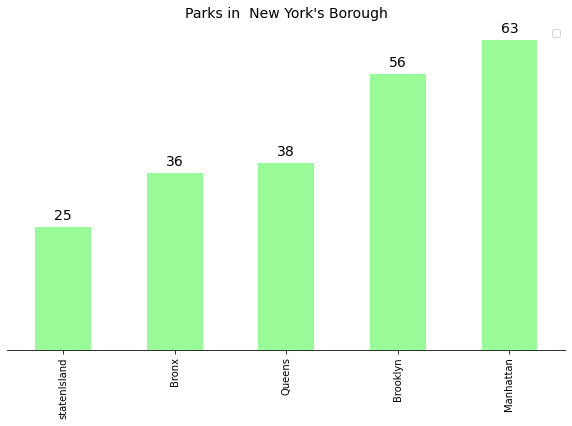

In [291]:
parks_count=newYork_parks.groupby(['Borough']).count()
parks_count.reset_index(inplace=True)
parks_count=parks_count.loc[0:,['Borough','Venue']]
parks_count.set_index('Borough', inplace=True)


ax=parks_count.sort_values('Venue',ascending=True).plot(kind='bar', figsize=(10,6),color='#98FB98')
ax.set_title("Parks in  New York's Borough", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('')
ax.set_yticks([])

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    #print(p,h,x)
    if h != 0:
        ax.annotate("%i" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=0, 
                  textcoords="offset points", ha="center", va="bottom",size = 14)
        
ax.legend("")

plt.show()

In [229]:
ny_park_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# add markers to map
for lat, lng, Neighborhood,venue,color in zip(newYork_parks['Venue Latitude'], newYork_parks['Venue Longitude'], newYork_parks['Neighborhood'],newYork_parks['Venue'], newYork_parks['color']):
    label='{}, {}'.format(venue,Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='grey',
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(ny_park_map)  
    
ny_park_map

> The above map shows the spread and concentration of park areas in New York's Borughs. We can observe that most of the parks that came under the list of preferences are located near the bay area



Parks are more generic locations when it comes to fitness activities and are more of places for recreation. This could be one of the reasons why parks came on top as the 1st common venue for many Neighborhoods

Hence we are gonna look at preferences for places like **gyms and sports complexes** in New York keeping *parks and playgrounds* out of the equation

### Availability

Now, before analysing the prefered fitness options, lets look at their availability/presence in different neighborhoods

P.S. : The dataframe is a curated list of popular venues per neighborhood based on FourSqaure API *(100 venues/500 m radius/neighborhood)*. There may be other places that are actually present but are out-of-scope of this analysis

The venues are broadly classified into the below broad categories from the exisitng categories to ease our analysis

In [230]:
gym_cat = ['Gym', 'Gym / Fitness Center', 'Climbing Gym', 'Gymnastics Gym', 'Boxing Gym', 'Pilates Studio', 
       'Martial Arts Dojo', 'Physical Therapist', 'College Gym', 'Weight Loss Center', 'Cycle Studio']

sports_cat=['Tennis Stadium', 'Sports Club', 'Athletics & Sports', 'Tennis Court', 'Golf Course', 'Volleyball Court', 'Mini Golf', 
            'Basketball Court','Soccer Field', 'Baseball Field','Soccer Field', 'Baseball Stadium',  'Golf Course', 'Stadium', 
            'Squash Court', 'Hockey Field', 'College Basketball Court', 'College Stadium']

swim_cat=['Pool', 'Gym Pool', 'Pool Hall']

TT_cat=['Bike Trail', 'Track','Trail']

Others=['Skate Park', 'Skating Rink', 'Surf Spot', 'Ski Area', 'Roller Rink','Dance Studio', 'Bowling Alley','Indoor Play Area',
       'Outdoors & Recreation', 'Rock Climbing Spot', 'Other Great Outdoors']

In [231]:
for i,category in enumerate(newYork_fitness_venues['Venue Category']):   
    #print(i,category)
    if category in gym_cat:
            newYork_fitness_venues.loc[i,'Category']='gym/fitness center'
            #break
    elif category in ['Yoga Studio']:
        newYork_fitness_venues.loc[i,'Category']='Yoga Studios'
    elif category in sports_cat:
           # print(category)
            newYork_fitness_venues.loc[i,'Category']='Sports'
    elif category in swim_cat:
            newYork_fitness_venues.loc[i,'Category']='Pool'
    elif category in TT_cat:
        newYork_fitness_venues.loc[i,'Category']='Track/Trail'
    elif category in Others:
        newYork_fitness_venues.loc[i,'Category']='Other venues'
    else:
        newYork_fitness_venues.loc[i,'Category']='Parks/Playgrounds'

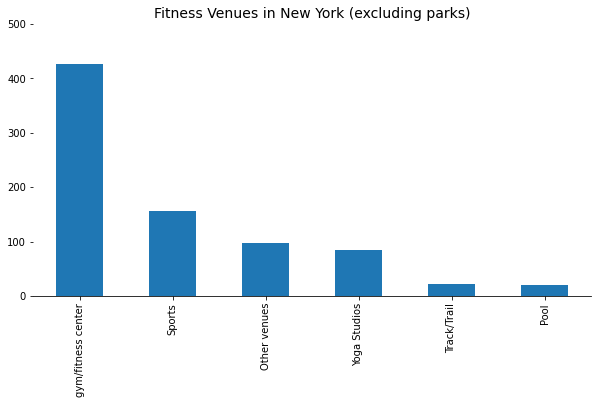

In [308]:
newYork_fitness_venues_wo_parks=newYork_fitness_venues[newYork_fitness_venues['Category'] != 'Parks/Playgrounds']
ax = newYork_fitness_venues_wo_parks['Category'].value_counts().plot(kind='bar', figsize=(10,5))
ax.set_title('Fitness Venues in New York (excluding parks)', fontsize=14)
ax.set_ylim([0,500])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [233]:
#venues_per_borough=venues_per_borough.reset_index()
venues_per_borough=newYork_fitness_venues_wo_parks.pivot_table(index='Borough', columns='Category', values='Venue',aggfunc='count')

del(venues_per_borough.index.name)
columns=['gym/fitness center','Yoga Studios','Sports','Pool','Track/Trail','Other venues']

venues_per_borough=venues_per_borough[columns]


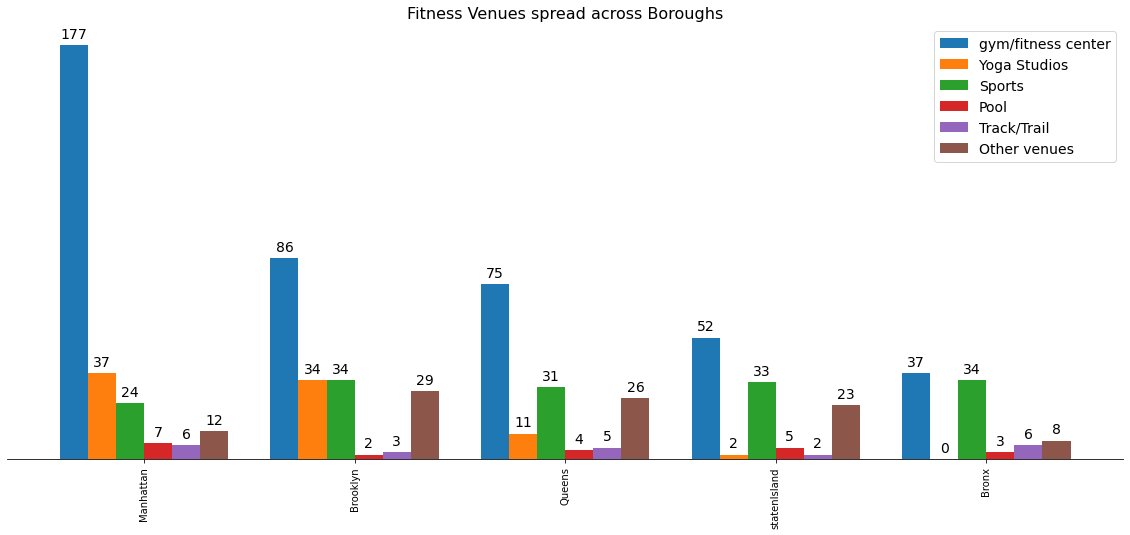

In [234]:
ordr=['Manhattan','Brooklyn','Queens','statenIsland','Bronx']
ax=venues_per_borough.sort_values('gym/fitness center', ascending=False).plot(kind='bar', figsize=(20,8),width=0.8, stacked=False)
ax.set_title('Fitness Venues spread across Boroughs', fontsize=16)
ax.set_yticks([])

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    #print(p,h,x)
    if h != 0:
        ax.annotate("%i" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=0, 
                  textcoords="offset points", ha="center", va="bottom",size = 14)
    else:
        ax.annotate("0", xy=(x,h), xytext=(0,4), rotation=0, 
                  textcoords="offset points", ha="center", va="bottom",size = 14)

ax.legend(fontsize=14)
spines=['top', 'left','right']
for spine in spines:
    ax.spines[spine].set_visible(False)

Lets see the spread of these fitness venues across the city of New York

In [235]:
#newYork_fitness_venues_wo_parks
newYork_fitness_venues_wo_parks['color'] = newYork_fitness_venues_wo_parks.loc[0:,'Category'].apply(lambda Category:'Orange' if Category=='gym/fitness center'
                                                        else 'blue' if Category=='Yoga Studios'
                                                        else 'red' if Category=='Pool'
                                                        else 'green' if Category=='Track/Trail'
                                                        else 'purple' if Category=='Sports'
                                                        else 'yellow')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [236]:
ny_fit_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

venues=plugins.MarkerCluster().add_to(ny_fit_map)
# add markers to map
for lat, lng, Neighborhood,venue,color in zip(newYork_fitness_venues_wo_parks['Venue Latitude'], newYork_fitness_venues_wo_parks['Venue Longitude'], 
                                              newYork_fitness_venues_wo_parks['Neighborhood'],newYork_fitness_venues_wo_parks['Venue'], newYork_fitness_venues_wo_parks['color']):
    label='{}, {}'.format(venue,Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        #radius=5,
        popup=label,
        #color='grey',
        #fill=True,
        #fill_color='yellow',
        #fill_opacity=0.7,
        parse_html=False).add_to(venues)  
    
ny_fit_map.add_child(MeasureControl())
ny_fit_map

### Dataframe and charts with Boroughs and fitness centers as a percentage of restaurants in each Borough

In [237]:
manhattan_resto=manhattan_venues[manhattan_venues.loc[0:,'Venue Category'].str.contains('restaurant', case=False)]
manhattan_resto.shape

(879, 7)

In [238]:
manhattan_fitness_per_neighborhood=manhattan_fitness_venues['Neighborhood'].value_counts().to_frame()
manhattan_resto_per_neighborhood=manhattan_resto['Neighborhood'].value_counts().to_frame()

In [239]:
manhattan_fitness_per_neighborhood.reset_index(inplace=True)
manhattan_fitness_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)
manhattan_fitness_per_neighborhood.head()

,Neighborhood,venue_count
0,Civic Center,22
1,Tribeca,18
2,Flatiron,16
3,Battery Park City,15
4,Lincoln Square,15


In [240]:
manhattan_resto_per_neighborhood.reset_index(inplace=True)
manhattan_resto_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)
manhattan_resto_per_neighborhood.head()

,Neighborhood,venue_count
0,Turtle Bay,38
1,Upper West Side,36
2,Chinatown,36
3,Murray Hill,35
4,Greenwich Village,35


In [241]:
manhattan_ratio=pd.DataFrame(columns=['Neighborhood','fitnessVenue/restaurant'])
n=[]

for n1,val1 in zip(manhattan_resto_per_neighborhood['Neighborhood'],manhattan_resto_per_neighborhood['venue_count']):
    for n2, val2 in zip(manhattan_fitness_per_neighborhood['Neighborhood'],manhattan_fitness_per_neighborhood['venue_count']):
        if n1==n2:
            val=val2/val1
    n.append([n1,round(val,2)])

In [242]:
for i in range(1,len(n)):
    manhattan_ratio.loc[i,'Neighborhood']=n[i][0]
    manhattan_ratio.loc[i,'fitnessVenue/restaurant']=n[i][1]

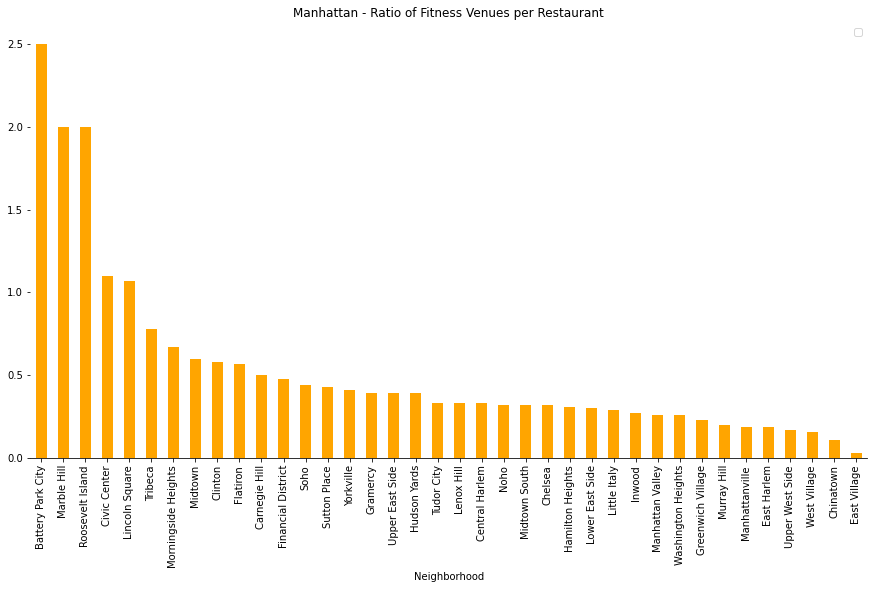

In [293]:
ax = manhattan_ratio.set_index('Neighborhood').sort_values('fitnessVenue/restaurant',ascending=False).plot(kind='bar',figsize=(15,8),color='orange')
ax.set_title('Manhattan - Ratio of Fitness Venues per Restaurant')
ax.legend('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [244]:
bronx_resto=Bronx_venues[Bronx_venues.loc[0:,'Venue Category'].str.contains('restaurant', case=False)]

bronx_fitness_per_neighborhood=bronx_fitness_venues['Neighborhood'].value_counts().to_frame()
bronx_resto_per_neighborhood=bronx_resto['Neighborhood'].value_counts().to_frame()
bronx_fitness_per_neighborhood.reset_index(inplace=True)
bronx_fitness_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)

bronx_resto_per_neighborhood.reset_index(inplace=True)
bronx_resto_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)

bronx_ratio=pd.DataFrame(columns=['Neighborhood','fitnessVenue/restaurant'])
n=[]
for n1,val1 in zip(bronx_resto_per_neighborhood['Neighborhood'],bronx_resto_per_neighborhood['venue_count']):
    for n2, val2 in zip(bronx_fitness_per_neighborhood['Neighborhood'],bronx_fitness_per_neighborhood['venue_count']):
        if n1==n2:
            val=val2/val1
    n.append([n1,round(val,2)])
for i in range(1,len(n)):
    bronx_ratio.loc[i,'Neighborhood']=n[i][0]
    bronx_ratio.loc[i,'fitnessVenue/restaurant']=n[i][1]

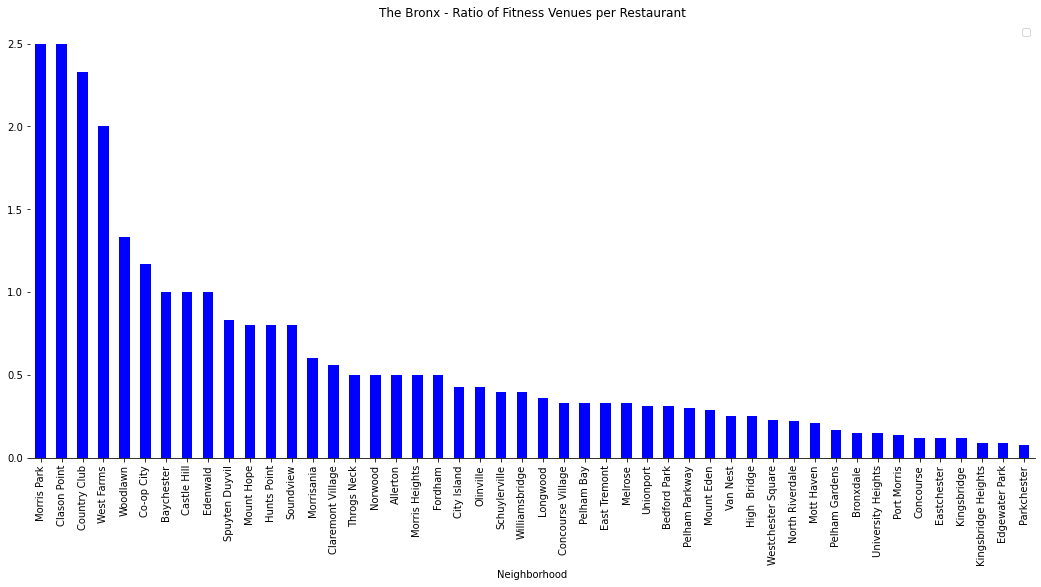

In [294]:
ax = bronx_ratio.set_index('Neighborhood').sort_values('fitnessVenue/restaurant',ascending=False).plot(kind='bar',figsize=(18,8),color='blue')
ax.set_title('The Bronx - Ratio of Fitness Venues per Restaurant')
ax.legend('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [246]:
brooklyn_resto=Brooklyn_venues[Brooklyn_venues.loc[0:,'Venue Category'].str.contains('restaurant', case=False)]

brooklyn_fitness_per_neighborhood=brooklyn_fitness_venues['Neighborhood'].value_counts().to_frame()
brooklyn_resto_per_neighborhood=brooklyn_resto['Neighborhood'].value_counts().to_frame()
brooklyn_fitness_per_neighborhood.reset_index(inplace=True)
brooklyn_fitness_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)

brooklyn_resto_per_neighborhood.reset_index(inplace=True)
brooklyn_resto_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)

brooklyn_ratio=pd.DataFrame(columns=['Neighborhood','fitnessVenue/restaurant'])
n=[]
for n1,val1 in zip(brooklyn_resto_per_neighborhood['Neighborhood'],brooklyn_resto_per_neighborhood['venue_count']):
    for n2, val2 in zip(brooklyn_fitness_per_neighborhood['Neighborhood'],brooklyn_fitness_per_neighborhood['venue_count']):
        if n1==n2:
            val=val2/val1
    n.append([n1,round(val,2)])
for i in range(1,len(n)):
    brooklyn_ratio.loc[i,'Neighborhood']=n[i][0]
    brooklyn_ratio.loc[i,'fitnessVenue/restaurant']=n[i][1]

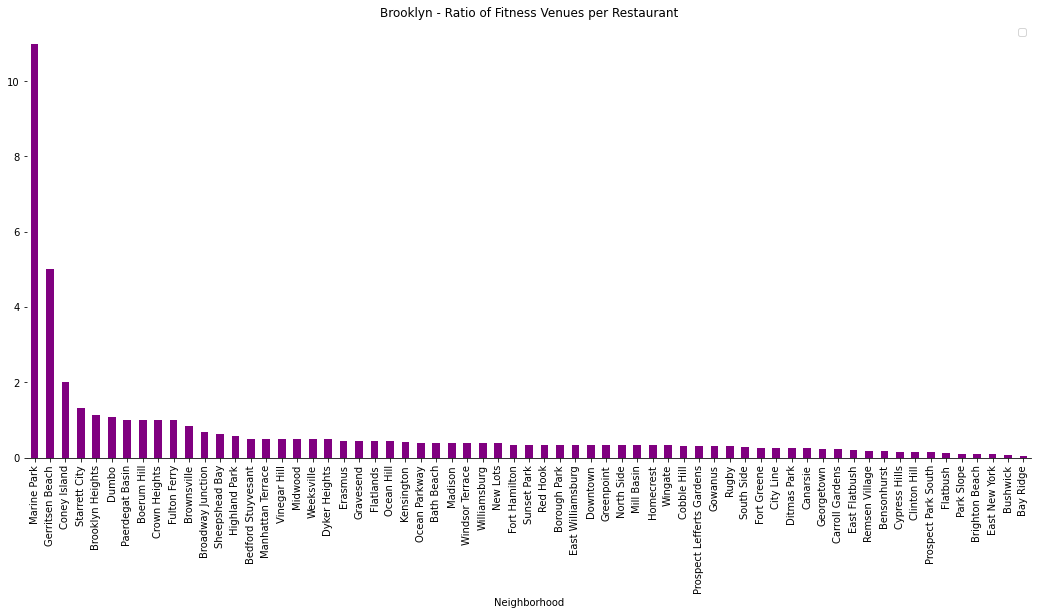

In [295]:
ax = brooklyn_ratio.set_index('Neighborhood').sort_values('fitnessVenue/restaurant',ascending=False).plot(kind='bar',figsize=(18,8),color='purple')
ax.set_title('Brooklyn - Ratio of Fitness Venues per Restaurant')
ax.legend('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [248]:
queens_resto=Queens_venues[Queens_venues.loc[0:,'Venue Category'].str.contains('restaurant', case=False)]

queens_fitness_per_neighborhood=queens_fitness_venues['Neighborhood'].value_counts().to_frame()
queens_resto_per_neighborhood=queens_resto['Neighborhood'].value_counts().to_frame()
queens_fitness_per_neighborhood.reset_index(inplace=True)
queens_fitness_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)

queens_resto_per_neighborhood.reset_index(inplace=True)
queens_resto_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)

queens_ratio=pd.DataFrame(columns=['Neighborhood','fitnessVenue/restaurant'])
n=[]
for n1,val1 in zip(queens_resto_per_neighborhood['Neighborhood'],queens_resto_per_neighborhood['venue_count']):
    for n2, val2 in zip(queens_fitness_per_neighborhood['Neighborhood'],queens_fitness_per_neighborhood['venue_count']):
        if n1==n2:
            val=val2/val1
    n.append([n1,round(val,2)])
for i in range(1,len(n)):
    queens_ratio.loc[i,'Neighborhood']=n[i][0]
    queens_ratio.loc[i,'fitnessVenue/restaurant']=n[i][1]

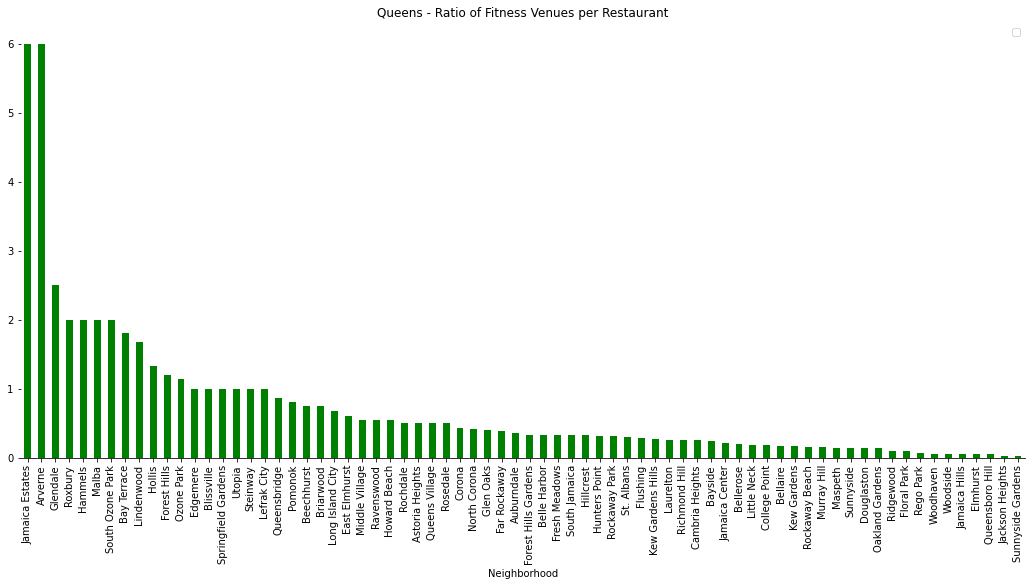

In [296]:
ax = queens_ratio.set_index('Neighborhood').sort_values('fitnessVenue/restaurant',ascending=False).plot(kind='bar',figsize=(18,8),color='green')
ax.set_title('Queens - Ratio of Fitness Venues per Restaurant')
ax.legend('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [250]:
statenIsland_resto=StatenIsland_venues[StatenIsland_venues.loc[0:,'Venue Category'].str.contains('restaurant', case=False)]

statenIsland_fitness_per_neighborhood=statenIsland_fitness_venues['Neighborhood'].value_counts().to_frame()
statenIsland_resto_per_neighborhood=statenIsland_resto['Neighborhood'].value_counts().to_frame()
statenIsland_fitness_per_neighborhood.reset_index(inplace=True)
statenIsland_fitness_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)

statenIsland_resto_per_neighborhood.reset_index(inplace=True)
statenIsland_resto_per_neighborhood.rename(columns={'index':'Neighborhood', 'Neighborhood':'venue_count'}, inplace=True)

statenIsland_ratio=pd.DataFrame(columns=['Neighborhood','fitnessVenue/restaurant'])
n=[]
for n1,val1 in zip(statenIsland_resto_per_neighborhood['Neighborhood'],statenIsland_resto_per_neighborhood['venue_count']):
    for n2, val2 in zip(statenIsland_fitness_per_neighborhood['Neighborhood'],statenIsland_fitness_per_neighborhood['venue_count']):
        if n1==n2:
            val=val2/val1
    n.append([n1,round(val,2)])
for i in range(1,len(n)):
    statenIsland_ratio.loc[i,'Neighborhood']=n[i][0]
    statenIsland_ratio.loc[i,'fitnessVenue/restaurant']=n[i][1]

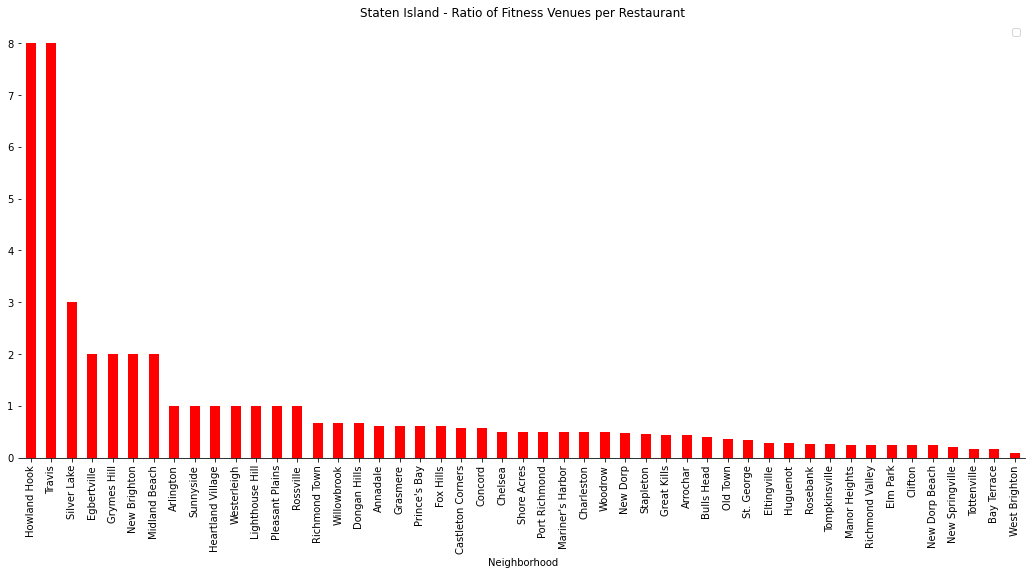

In [297]:
ax = statenIsland_ratio.set_index('Neighborhood').sort_values('fitnessVenue/restaurant',ascending=False).plot(kind='bar',figsize=(18,8),color='red')
ax.set_title('Staten Island - Ratio of Fitness Venues per Restaurant')
ax.legend('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### Combined fitness data of new york city and clustered them

In [303]:
# one hot encoding
newyork_onehot = pd.get_dummies(newYork_fitness_venues_wo_parks[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newYork_fitness_venues_wo_parks['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

In [304]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
#newyork_grouped

The fitness centers across New York are grouped under the broad categories and the *top 3* preferences are derived for each **Neighborhood**

In [305]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
newyork_fitness_venues_sorted = pd.DataFrame(columns=columns)
newyork_fitness_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    newyork_fitness_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

#newyork_fitness_venues_sorted.head()

**Lets see if we can identify some patterns in these preferences by clustering them using *KMeans* clustering **

In [306]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 3, 3, 0, 3, 2, 3, 2, 0], dtype=int32)

In [307]:
# add clustering labels
newyork_fitness_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_merged = newYork_fitness_venues_wo_parks

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(newyork_fitness_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#newyork_merged.head()

In [257]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Venue Latitude'], newyork_merged['Venue Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [258]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Category,color,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
4,Washington Heights,40.848562,-73.936941,Gym,gym/fitness center,Orange,0,gym/fitness center,Pool,Yoga Studios
6,Central Harlem,40.812608,-73.939699,Gym,gym/fitness center,Orange,0,gym/fitness center,Yoga Studios,Track/Trail
8,Yorkville,40.775625,-73.947402,Gym,gym/fitness center,Orange,0,gym/fitness center,Sports,Pool
9,Yorkville,40.777947,-73.949378,Gym,gym/fitness center,Orange,0,gym/fitness center,Sports,Pool
10,Yorkville,40.779062,-73.944095,Gym,gym/fitness center,Orange,0,gym/fitness center,Sports,Pool
...,...,...,...,...,...,...,...,...,...,...
979,Lindenwood,40.662833,-73.852720,Weight Loss Center,gym/fitness center,Orange,0,gym/fitness center,Other venues,Yoga Studios
993,Howard Beach,40.651928,-73.837653,Sports Club,Sports,purple,0,gym/fitness center,Sports,Other venues
1026,Flushing,40.766154,-73.831431,Pool Hall,Pool,red,0,gym/fitness center,Pool,Yoga Studios
1111,Lindenwood,40.666577,-73.851563,Dance Studio,Other venues,yellow,0,gym/fitness center,Other venues,Yoga Studios


The neighborhoods in cluster 1 have *gym/fitness centers* as the most common venue

### Cluster 2

In [259]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Category,color,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
222,Morningside Heights,40.811358,-73.965748,Tennis Court,Sports,purple,1,Sports,gym/fitness center,Yoga Studios
223,Morningside Heights,40.811324,-73.965724,Tennis Court,Sports,purple,1,Sports,gym/fitness center,Yoga Studios
345,Bedford Park,40.873893,-73.888768,Gym,gym/fitness center,Orange,1,Sports,gym/fitness center,Yoga Studios
381,Spuyten Duyvil,40.878628,-73.914568,Tennis Stadium,Sports,purple,1,Sports,gym/fitness center,Yoga Studios
383,Fieldston,40.894779,-73.905598,Athletics & Sports,Sports,purple,1,Sports,gym/fitness center,Yoga Studios
...,...,...,...,...,...,...,...,...,...,...
1019,Rockaway Beach,40.584960,-73.821430,Golf Course,Sports,purple,1,Sports,gym/fitness center,Yoga Studios
1021,Hillcrest,40.724029,-73.794458,College Basketball Court,Sports,purple,1,Sports,gym/fitness center,Yoga Studios
1022,Hillcrest,40.723030,-73.796101,College Stadium,Sports,purple,1,Sports,gym/fitness center,Yoga Studios
1031,Roxbury,40.567476,-73.891433,Trail,Track/Trail,green,1,Track/Trail,Sports,gym/fitness center


The neighborhoods in cluster 2 have **sports** venues as the most common venue

### Cluster 3

In [260]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Category,color,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Marble Hill,40.876705,-73.906372,Gym,gym/fitness center,Orange,2,gym/fitness center,Yoga Studios,Sports
1,Marble Hill,40.877271,-73.905595,Gym,gym/fitness center,Orange,2,gym/fitness center,Yoga Studios,Sports
2,Chinatown,40.717812,-73.992624,Gym,gym/fitness center,Orange,2,gym/fitness center,Yoga Studios,Sports
3,Chinatown,40.718700,-73.992028,Gym,gym/fitness center,Orange,2,gym/fitness center,Yoga Studios,Sports
5,Hamilton Heights,40.826827,-73.949984,Gym,gym/fitness center,Orange,2,Yoga Studios,gym/fitness center,Track/Trail
...,...,...,...,...,...,...,...,...,...,...
1113,Ozone Park,40.679797,-73.840457,Bowling Alley,Other venues,yellow,2,gym/fitness center,Other venues,Yoga Studios
1117,Hunters Point,40.746423,-73.951848,Bowling Alley,Other venues,yellow,2,gym/fitness center,Yoga Studios,Track/Trail
1119,Little Neck,40.771499,-73.734334,Indoor Play Area,Other venues,yellow,2,gym/fitness center,Other venues,Sports
1120,Little Neck,40.772553,-73.733803,Outdoors & Recreation,Other venues,yellow,2,gym/fitness center,Other venues,Sports


This cluster seems to have neighborhoods that have preference towards gyms and yoga studios

### Cluster 4

In [261]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Category,color,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
477,Williamsbridge,40.882686,-73.862978,Dance Studio,Other venues,yellow,3,Other venues,gym/fitness center,Yoga Studios
478,East Tremont,40.844950,-73.887340,Dance Studio,Other venues,yellow,3,Other venues,gym/fitness center,Yoga Studios
481,Eastchester,40.886020,-73.823207,Bowling Alley,Other venues,yellow,3,Other venues,gym/fitness center,Yoga Studios
483,East Tremont,40.845818,-73.884549,Outdoors & Recreation,Other venues,yellow,3,Other venues,gym/fitness center,Yoga Studios
585,Gowanus,40.676820,-73.998652,Yoga Studio,Yoga Studios,blue,3,Yoga Studios,Other venues,gym/fitness center
643,Fulton Ferry,40.704328,-73.994547,Trail,Track/Trail,green,3,Track/Trail,Other venues,gym/fitness center
647,Bath Beach,40.595941,-74.000917,Surf Spot,Other venues,yellow,3,Other venues,gym/fitness center,Yoga Studios
648,City Line,40.681956,-73.866227,Ski Area,Other venues,yellow,3,Other venues,gym/fitness center,Yoga Studios
649,Fulton Ferry,40.699822,-73.998349,Roller Rink,Other venues,yellow,3,Track/Trail,Other venues,gym/fitness center
737,Gowanus,40.670342,-73.991967,Dance Studio,Other venues,yellow,3,Yoga Studios,Other venues,gym/fitness center


cluster 4 has neighborhoods that have other venues like *bowling alleys, ski places, surfing and skating rinks* as their most common venues

## Conclusion

The main aim of this notebook is to give an idea about how a model city like New York set their fitness preferences. Health & Fitness as industry could gain from analysing these preferences and thereby understanding the expectations of the population of a locality before starting an establishment like a gym or sports arena. This is going to be crucial with increasing emphasis on physical fitness and health amidst the current COVID-19 crisis since general immunity plays a crucial factor. 
